In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import random
from scipy.stats import ttest_1samp

import pickle


def load_data(parent_path, folder_name, file_name):
    path = parent_path / folder_name / file_name
    return pd.read_csv(path)


def plot_histograms(data,
                    target, target_figsize,
                    dependent_layout, dependent_figsize,
                    include_boxplots=False, boxplot_figsize=None):
    print(f"Distribution of target {target} and dependent variables:")
    data[target].hist(figsize=target_figsize, grid=False).set_title(target)
    data.drop([target], axis=1).hist(layout=dependent_layout, figsize=dependent_figsize, sharey=True, grid=False)

    if include_boxplots:
        data.plot(kind='box', subplots=True, figsize=boxplot_figsize);
        
    plt.tight_layout();


def hypothesis_test(values, target, alpha, model, figsize):
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout(pad=5)
    print(f"Hypothesis test for {type(model).__name__}")
    t_stat, pvalue = ttest_1samp(values, target)
    null_hypothesis = f"Mean test score is not significantly different from {target} at alpha={alpha}."
    print(f"Null hypothesis - {null_hypothesis}\n")

    print("Result:")
    if pvalue/2 > alpha:
        print(f"Failed to reject the null hypothesis: {null_hypothesis}")
    else:
        if t_stat > 0:
            print(f"Rejected the null hypothesis - Mean test score is greater than {target} at alpha={alpha}.")
        else:
            print(f"Rejected the null hypothesis - Mean test score is smaller than {target} at alpha={alpha}.")
    print()

    sns.histplot(values, ax=ax)
    # ax.vlines(np.mean(scores), 0, 10, colors='red')
    ax.text(0, 0,
        f"""
        Mean: {round(np.mean(values), 4)}
        Std: {round(np.std(values), 4)}
        Max: {round(np.max(values), 4)}
        Min: {round(np.min(values), 4)}
        """)
    ax.set_title(type(model).__name__)
    ax.set_xlabel("Accuracy Score")
    ax.set_xbound(0, 1)


def transform_fit_predict(X_train, y_train, X_test, y_test,
                          resample, resampling_method,
                          normalize_scale,
                          random_state,
                          cv_n_splits, cv_n_repeats,
                          method,
                          save_model=False, path=None):
    if resample:
        total_count = y_test.count()
        if resampling_method=='upsample':
            upsample_count = y_test.value_counts().max()
            resample_index = random.choices(np.arange(0, total_count, 1), k=upsample_count)
        elif resampling_method=='downsample':
            downsample_count = y_test.value_counts().min()
            resample_index = random.choices(np.arange(0, total_count, 1), k=downsample_count)
    
        X_train = X_train.iloc[resample_index]
        y_train = y_train.iloc[resample_index]

    if normalize_scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    xgb_clf = XGBClassifier(seed=random_state)
    xgb_clf.fit(X_train, y_train)
    if save_model:
        with open(path / "trained_model.sav", 'wb') as f:
            pickle.dump(xgb_clf, f)
        print(f"Trained model saved: {path}")
            
    scores = cross_val_score(xgb_clf, X_test, y_test, scoring='roc_auc',
                            cv=RepeatedStratifiedKFold(n_splits=cv_n_splits, n_repeats=cv_n_repeats))
    print(f"{method}: {np.mean(scores)}")

#### 1. <b>Load and explore data</b>

In [2]:
parent_path = Path(os.getcwd()).parent
file_name = "term-deposit-marketing-2020.csv"
folder_name = "data"
data = load_data(parent_path, folder_name, file_name)
print(data.head(), "\n")
print(data.info(), "\n")
data.describe()

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object


,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


The data set consists of different data types.

Convert the type of "day" from int64 to object/categorical.

In [3]:
data['day'] = data['day'].astype(str)

Take a look at the distribution of the target variable "y" and dependent variables that are numeric.

Distribution of target y and dependent variables:


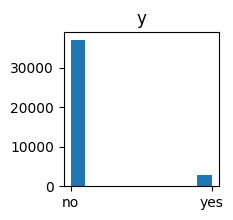

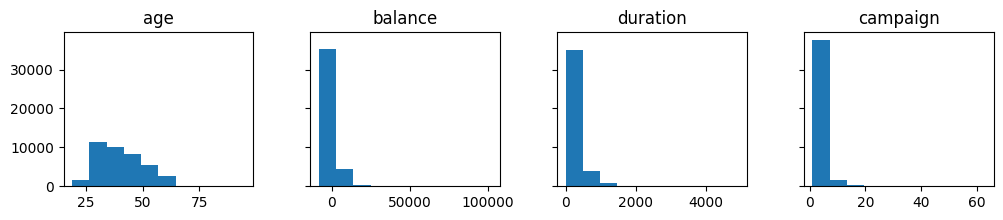

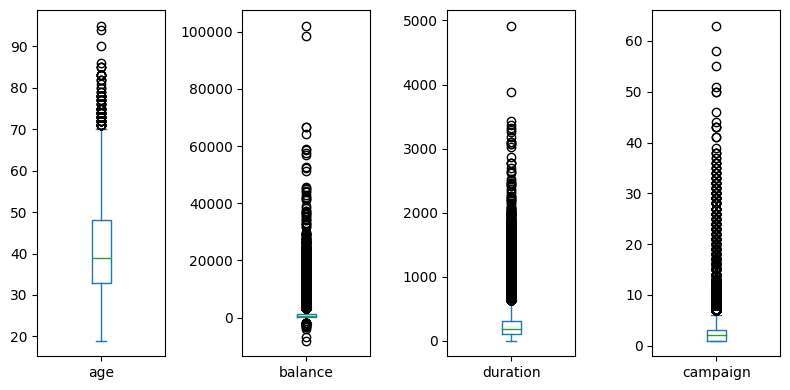

In [4]:
plot_histograms(data=data,
                target="y", target_figsize=(2,2),
                dependent_layout=(1,4), dependent_figsize=(12, 2),
                include_boxplots=True, boxplot_figsize=(8, 4))

##### <b>1.1 Findings</b>

Firt of all, the target class is highly imbalanced. Let's look at the value counts and proportions.

In [5]:
print(data["y"].value_counts())
print()
print(data["y"].value_counts() / data["y"].value_counts().sum())

no     37104
yes     2896
Name: y, dtype: int64

no     0.9276
yes    0.0724
Name: y, dtype: float64


The minority class (i.e. "yes") only accounts for about 7% of the target variable, but it still has close to 3K instances/rows, which could be enough for model tranining.<br>
We can try downsampling, upsampling, of both, but this will need to be done <b>after</b> separating test data from the original data set to prevent data leakage.

Secondly, the numeric variables are highly skewed to the right, meaning there are outliers on the right side, which is confirmed by the boxplots (i.e. there is a small number of data points on the top of the boxplots).<br>
Also, they are in widely different scales (e.g. the scale of the age variable and the balance variable are very different), which will not be helpful in model training and evaluation.<br>
For these reasons, the numeric variables will be normalized using sklearn's StandardScaler after splitting the data into train and test sets.

Lastly, in addition to the numeric variables we've looked at, we also have categorical variables. Those categorical variables will need to be converted into numeric, including the target variable, so that machine learning models can learn from the data. panda's get_dummies method will be used for that operation.<br>
* The target variable will be manually converted from "no" to 0 and from "yes" to 1 without using the encoder so that "no" would not be converted to 1, which is not intuitive in practice and might cause misunderstanding.

In [6]:
X_original = data.drop(["y"], axis=1)
y_original = data["y"]
y = y_original.apply(lambda x: 1 if x=="yes" else 0)

X = pd.DataFrame()
for col in X_original.columns:
    if type(X_original[col][0]) == str:
        col_pivoted = pd.get_dummies(X_original[col], prefix=col)
        X = pd.concat([X, col_pivoted], axis=1)
    else:
        X = pd.concat([X, X_original[col]], axis=1)

X.describe()

,age,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,0.112075,0.234575,0.035125,0.027175,0.204150,0.035925,0.035350,0.09775,0.013100,...,0.057400,0.029400,0.159500,0.118350,0.006450,0.338300,0.089950,0.002000,254.824300,2.882175
std,9.641776,0.315463,0.423738,0.184098,0.162595,0.403084,0.186106,0.184665,0.29698,0.113704,...,0.232608,0.168927,0.366146,0.323026,0.080053,0.473137,0.286114,0.044677,259.366498,3.239051
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000
50%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,175.000000,2.000000
75%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,313.000000,3.000000
max,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4918.000000,63.000000


#### 2. <b>Split and transform data</b>
Before performing any transformation to the data, first split it intotrain and test sets.

In [7]:
# test_size = 0.2
# random_state = 1
# X_train, X_test, y_train, y_test = \
#     train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

After the split, resample only the train data to deal with the imbalance of the target variable; the test data shouldn't be resampled. We could try both upsampling and downsampling techniques to see which one gives us better results.

In [8]:
# total_count = y_test.count()
# upsample_count = y_test.value_counts().max()
# downsample_count = y_test.value_counts().min()

# # resample_index = random.choices(np.arange(0, total_count, 1), k=upsample_count)
# resample_index = random.choices(np.arange(0, total_count, 1), k=downsample_count)
# X_train_balanced = X_train.iloc[resample_index]
# y_train_balanced = y_train.iloc[resample_index]

Next, normalize the dependent variables using sklearn's StandardScaler as mentioned above so that they will be on the same scale.

In [9]:
# scaler = StandardScaler()
# X_train_normalized = scaler.fit_transform(X_train_balanced)
# X_test_normalized = scaler.transform(X_test)

#### <b>3. Train, evaluate, and save model</b>

As preprocessing steps have been completed, it's time to train XGBClassifier using the train data and cross-validate prediction scores on the test data.

In [10]:
# xgb_clf = XGBClassifier(seed=random_state)
# xgb_clf.fit(X_train_normalized, y_train_balanced)
# scores = cross_val_score(xgb_clf, X_test, y_test, scoring='roc_auc',
#                          cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10))
# hypothesis_test(values=scores, target=0.81, alpha=0.05, model=xgb_clf, figsize=(5,5))

The prediction accuracy was over 90%. Now put all the steps after the train-test split to see how prediction accuracies vary depending on different data transformations performed on the data.

In [11]:
# transform_fit_predict(X_train, y_train, X_test, y_test,
#                       resample=False, resampling_method=None,
#                       normalize_scale=False,
#                       random_state=random_state,
#                       cv_n_splits=5, cv_n_repeats=10,
#                       method='No resampling nor normalizing scales')

In [12]:
# transform_fit_predict(X_train, y_train, X_test, y_test,
#                       resample=False, resampling_method=None,
#                       normalize_scale=True,
#                       random_state=random_state,
#                       cv_n_splits=5, cv_n_repeats=10,
#                       method='No resampling but normalizing scales')

Normalizing scales turns out to be not significantly impactful, probably because there are only 4 numeric variables to normalize and other dependent variables are all binary (i.e. either 0 or 1). Having said that, the mean prediction accuracy was better with normalization.<br>
<br>
Now check whether upsampling or downsampling results in better prediction accuracies.

In [13]:
# transform_fit_predict(X_train, y_train, X_test, y_test,
#                       resample=True, resampling_method='upsample',
#                       normalize_scale=True,
#                       random_state=random_state,
#                       cv_n_splits=5, cv_n_repeats=10,
#                       method='Upsampling with normalizing scales')

In [14]:
# transform_fit_predict(X_train, y_train, X_test, y_test,
#                       resample=True, resampling_method='downsample',
#                       normalize_scale=True,
#                       random_state=random_state,
#                       cv_n_splits=5, cv_n_repeats=10,
#                       method='Downsampling with normalizing scales')

Based on this little experiment above, upsampling with normalizing scales produced the highest mean prediction accuracy score. Hence, save the model trained with an upsampled target variable and normalized dependent variables.<br>
<br>
Lastly, try the cross-validation on the test data 100 times instead of 10 to give more statistical power to the result.

In [15]:
# transform_fit_predict(X_train, y_train, X_test, y_test,
#                       resample=True, resampling_method='upsample',
#                       normalize_scale=True,
#                       random_state=random_state,
#                       cv_n_splits=5, cv_n_repeats=100,
#                       method='Downsampling with normalizing scales',
#                       save_model=True, path=Path(os.getcwd()).parent)

The average 5-fold cross-validation accuracy score was still above 81.<br>

Since we have already achieved the target accuracy score, no model selection or hyperparameter tuning would be necessary for the time being.

#### <b>4. Identify customer segments</b>

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

=> analyze the customers/rows where the y column value is "yes".
: this can be done but would be meaningless if the characteristics of the customers who subscribed are similar to the customers who didn't subscribe. Thus, will look at both distributions of each column, grouped by whether the customers subscribed or not.


we will need to look at numeric and non-numeric columns differently as the types of data are different. For this reason, get numeric and non-numeric columns from the data set.

In [29]:
numeric_columns = []
non_numeric_columns = []
for col in data.drop(["y"], axis=1).columns:
    if type(data[col][0]) == str:
        non_numeric_columns.append(col)
    else:
        numeric_columns.append(col)

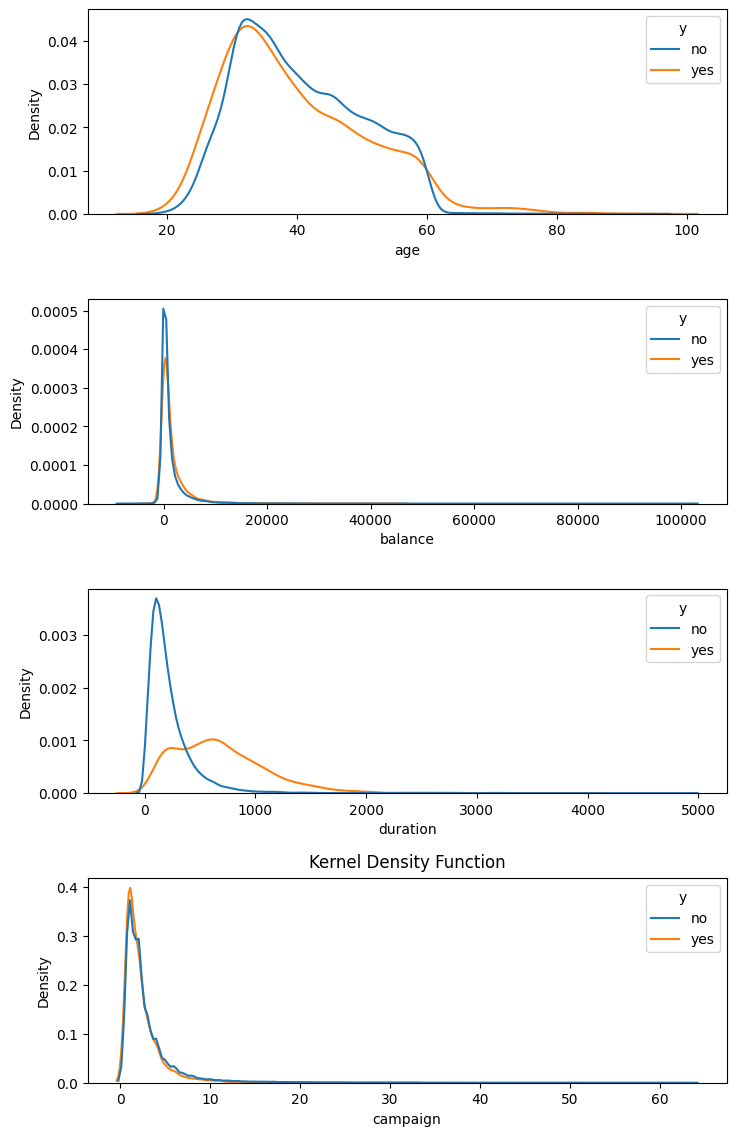

In [68]:
fix, axes = plt.subplots(4,1, figsize=(8, 12))
for i, col in enumerate(numeric_columns):
    sns.kdeplot(data=data, x=col, hue='y', common_norm=False, ax=axes[i])
plt.tight_layout(pad=3)
plt.title("Kernel Density Function", y=1.01);

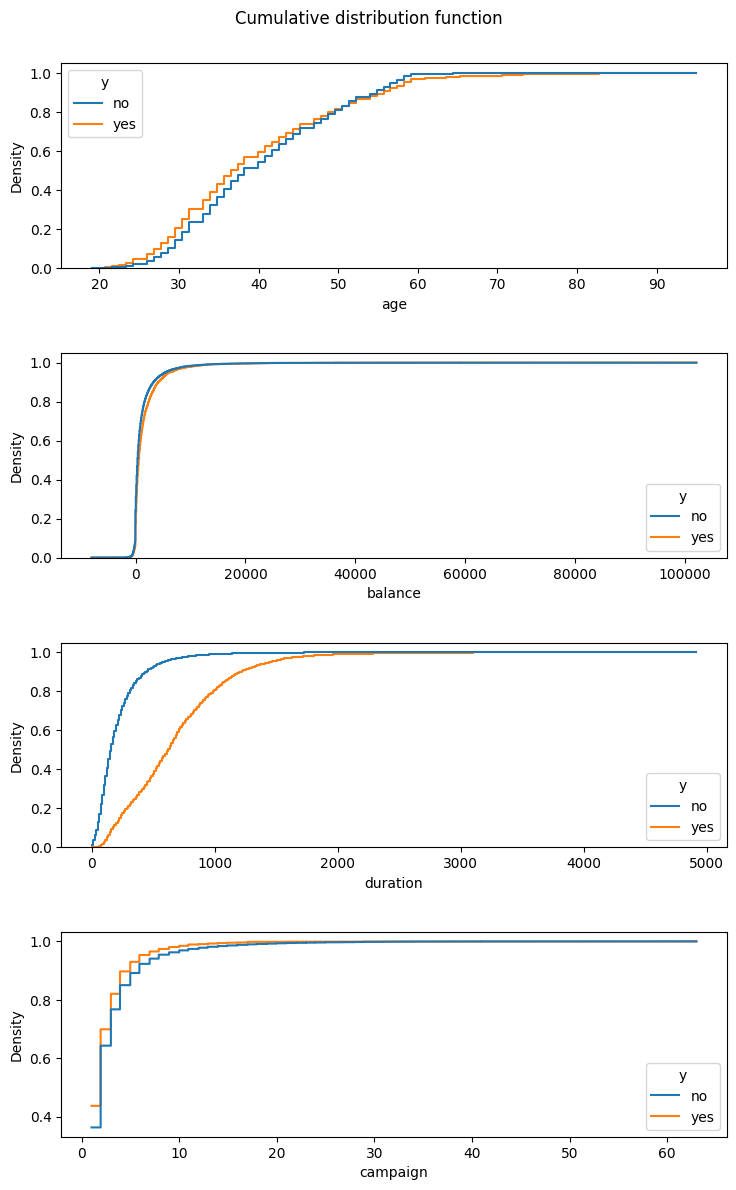

In [67]:
fix, axes = plt.subplots(4,1, figsize=(8, 12))
for i, col in enumerate(numeric_columns):
    sns.histplot(data=data, x=col, hue='y', common_norm=False, ax=axes[i],
                 stat='density', element='step', fill=False, cumulative=True)
plt.tight_layout(pad=3)
plt.suptitle("Cumulative distribution function", y=1.01);

In [71]:
from causalml.match import create_table_one
create_table_one(data, data[data['y']=='yes'], numeric_columns)

ModuleNotFoundError: No module named 'causalml'

chi-square test for non-numeric columns

#### <b>5. Identify more important features</b>

What makes the customers buy? Tell us which feature we should be focusing more on.
=> check feature importances

In [14]:
xgb_clf.feature_importances_

array([0.00129588, 0.0056054 , 0.01061742, 0.00582657, 0.00548151,
       0.01063287, 0.00548122, 0.00480713, 0.00977681, 0.00353171,
       0.01155604, 0.00619368, 0.0024687 , 0.0693954 , 0.01684836,
       0.02767983, 0.02631562, 0.0126255 , 0.02100228, 0.03894221,
       0.00126845, 0.0010093 , 0.0015009 , 0.09871136, 0.12073225,
       0.01012163, 0.01986355, 0.00555588, 0.01651951, 0.08103521,
       0.00169077, 0.00366467, 0.00374191, 0.00155264, 0.00142494,
       0.00266061, 0.0024435 , 0.00206698, 0.00440258, 0.00170805,
       0.00252832, 0.00358921, 0.00341658, 0.00150453, 0.00184903,
       0.00122723, 0.00098199, 0.00235714, 0.00117496, 0.00133296,
       0.00295072, 0.00191067, 0.00401177, 0.00240923, 0.00123877,
       0.00370291, 0.0034287 , 0.00407589, 0.00385777, 0.00240045,
       0.00203104, 0.01596044, 0.05250814, 0.        , 0.01176248,
       0.0360489 , 0.03226461, 0.01517027, 0.00144849, 0.02475934,
       0.03715429, 0.00850193, 0.03125125, 0.00343104], dtype=